# VAEの実装プラクティス V1

- コードの参考URL
  - [Pytorchによる変分オートエンコーダー\(VAE\)実装 \- deepblue](https://deepblue-ts.co.jp/image-generation/pytorch_vae/)


- 数式・理論の解説
  - [【超初心者向け】VAEの分かりやすい説明とPyTorchの実装｜Beginaid](https://tips-memo.com/vae-pytorch#VAE-2)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
import torch.utils as utils
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# データセットのロード
def setup_data_loaders(batch_size=128, use_cuda=True):
    root = "./data/mnist"
    download=True
    # 画像にどのような前処理を施すか設定します。
    # ToTensor()の他にもサイズを変更するResize()や標準化を行うnormalize()などを指定できます。
    trans = transforms.ToTensor()
    # まず、torchvision.datasetsからMNISTという手書き数字のデータセットを読み込みます。
    train_set = datasets.MNIST(root=root, train=True, transform=trans, download=download)
    valid_set = datasets.MNIST(root=root, train=False, transform=trans)
    # データセットをbatch_size個のデータごとに小分けにしたものにして、ミニバッチ学習が可能なようにします。
    # shuffle=True　にすると画像の順序がランダムになったりしますが、ここらへんはどっちでもいいと思います。
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader

In [3]:
class VAE(nn.Module): # nn.Moduleクラスを引き継ぎ
    def __init__(self, z_dim, x_dim=28*28):
        super(VAE, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim
        
        # エンコーダー用の関数
        self.fc1 = nn.Linear(x_dim, 20)
        self.fc2_mean = nn.Linear(20, z_dim)
        self.fc2_var = nn.Linear(20, z_dim)
        # デコーダー用の関数
        self.fc3 = nn.Linear(z_dim, 20)
        self.fc4 = nn.Linear(20, x_dim)

    # エンコーダー
    def encoder(self, x):
        x = x.view(-1, self.x_dim)
        x = F.relu(self.fc1(x))
        mean = self.fc2_mean(x) # 平均
        log_var = self.fc2_var(x) # 分散の対数
        return mean, log_var
    # デコーダー
    def decoder(self, z):
        y = F.relu(self.fc3(z))
        y = torch.sigmoid(self.fc4(y)) # 各要素にシグモイド関数を適用し、値を(0,1)の範囲に
        return y

    # 潜在ベクトルのサンプリング(再パラメータ化)
    def reparametrizaion(self, mean, log_var, device):
        epsilon = torch.randn(mean.shape, device=device)
        return mean + epsilon*torch.exp(0.5 * log_var)


    def forward(self, x, device):
        x = x.view(-1, self.x_dim)
        mean, log_var = self.encoder(x) # 画像xを入力して、平均・分散を出力
        KL = 0.5 * torch.sum(1+log_var - mean**2 - torch.exp(log_var)) # KL[q(z|x)||p(z)]を計算
        z = self.reparametrizaion(mean, log_var, device) # 潜在ベクトルをサンプリング(再パラメータ化)
        x_hat = self.decoder(z) # 潜在ベクトルを入力して、再構築画像 y を出力
        reconstruction = torch.sum(x * torch.log(x_hat+1e-8) + (1 - x) * torch.log(1 - x_hat  + 1e-8)) #E[log p(x|z)]
        lower_bound = -(KL + reconstruction) #変分下界(ELBO)=E[log p(x|z)] - KL[q(z|x)||p(z)]
        return lower_bound , z, x_hat

In [4]:
# モデル学習
dataloader_train, dataloader_valid = setup_data_loaders(batch_size=1000) # データローダーを作成
model = VAE(z_dim = 10).to(device) # モデルをインスタンス化し、GPUにのせる
optimizer = optim.Adam(model.parameters(), lr=1e-3) # オプティマイザーの設定
model.train() # モデルを訓練モードに
num_epochs = 40
loss_list = []
for i in range(num_epochs):
    losses = []
    for x, t in dataloader_train: # データローダーからデータを取り出す。
        x = x.to(device) # データをGPUにのせる
        loss, z, y = model(x, device) # 損失関数の値 loss 、潜在ベクトル z 、再構築画像 y を出力
        model.zero_grad() # モデルの勾配を初期化
        loss.backward() # モデル内のパラメータの勾配を計算
        optimizer.step() # 最適化を実行
        losses.append(loss.cpu().detach().numpy()) # ミニバッチの損失を記録
    loss_list.append(np.average(losses)) # バッチ全体の損失を登録
    print("EPOCH: {} loss: {}".format(i, np.average(losses)))


EPOCH: 0 loss: 446771.71875
EPOCH: 1 loss: 253420.015625
EPOCH: 2 loss: 226031.453125
EPOCH: 3 loss: 212227.53125
EPOCH: 4 loss: 201595.65625
EPOCH: 5 loss: 192759.484375
EPOCH: 6 loss: 183911.46875
EPOCH: 7 loss: 177258.921875
EPOCH: 8 loss: 172487.28125
EPOCH: 9 loss: 168616.828125
EPOCH: 10 loss: 165716.0625
EPOCH: 11 loss: 163580.859375
EPOCH: 12 loss: 161821.0
EPOCH: 13 loss: 160561.09375
EPOCH: 14 loss: 159592.609375
EPOCH: 15 loss: 158850.234375
EPOCH: 16 loss: 158193.390625
EPOCH: 17 loss: 157695.0
EPOCH: 18 loss: 157180.421875
EPOCH: 19 loss: 156745.859375
EPOCH: 20 loss: 156307.71875
EPOCH: 21 loss: 155859.828125
EPOCH: 22 loss: 155431.828125
EPOCH: 23 loss: 154921.4375
EPOCH: 24 loss: 154407.25
EPOCH: 25 loss: 153786.15625
EPOCH: 26 loss: 153080.953125
EPOCH: 27 loss: 152297.234375
EPOCH: 28 loss: 151502.140625
EPOCH: 29 loss: 150878.578125
EPOCH: 30 loss: 150262.171875
EPOCH: 31 loss: 149698.890625
EPOCH: 32 loss: 149111.796875
EPOCH: 33 loss: 148562.1875
EPOCH: 34 loss: 14

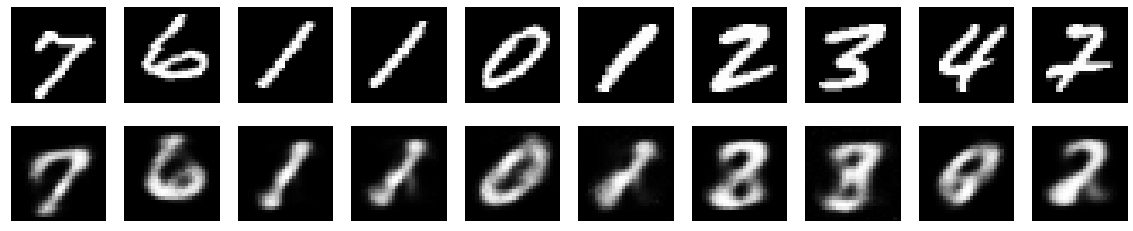

In [5]:
fig = plt.figure(figsize=(20,4))
model.eval()
zs = []
for x, t in dataloader_valid:
    for i, im in enumerate(x.view(-1,28,28).detach().numpy()[:10]):
        # 元画像を可視化
        ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
        ax.imshow(im, "gray")
    x = x.to(device)
    _, _, y = model(x, device) #再構築画像 y を出力
    y  = y.view(-1,28,28)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
        # 再構築画像を可視化
        ax = fig.add_subplot(2,10,11+i, xticks=[], yticks=[])
        ax.imshow(im, "gray")

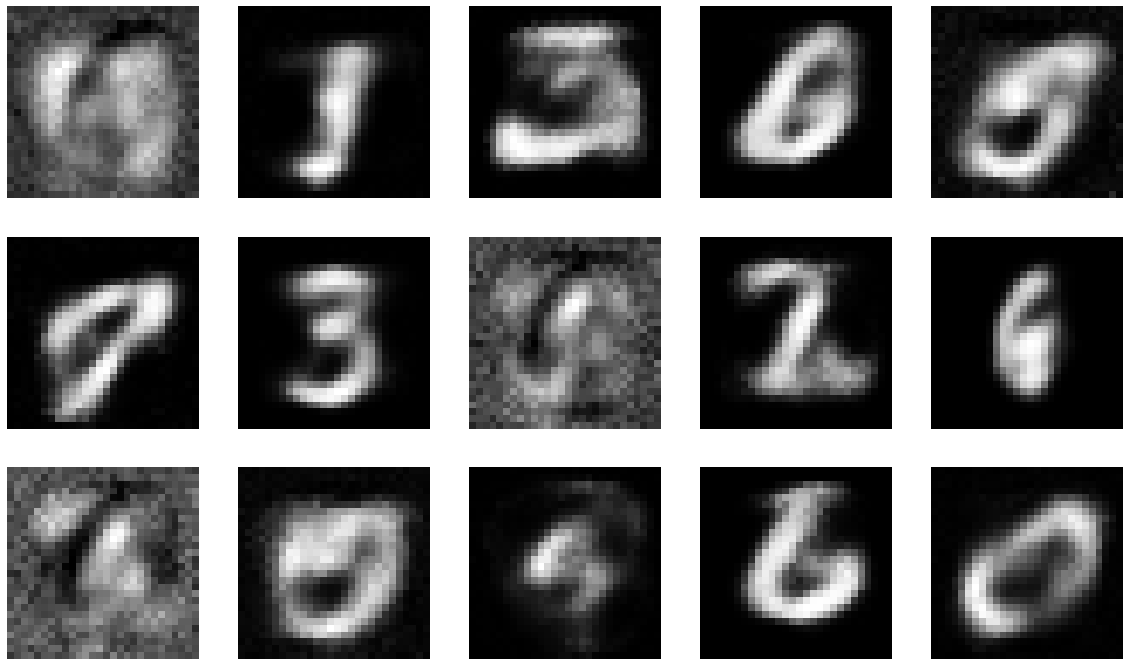

In [6]:
# 正規乱数から画像生成
fig, ax = plt.subplots(nrows = 3, ncols=5, figsize=(20,12))
model.eval()
for r in range(3):
    for c in range(5):
        ax[r,c].imshow(model.decoder(torch.randn(10).cuda()).detach().cpu().numpy().reshape(28,28), cmap="gray")
        ax[r,c].axis("off")

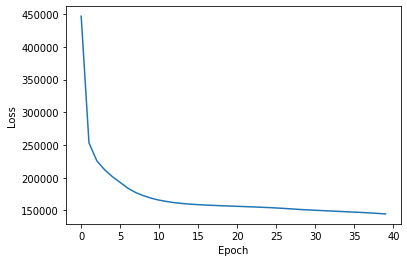

In [7]:
plt.plot(range(len(loss_list)), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

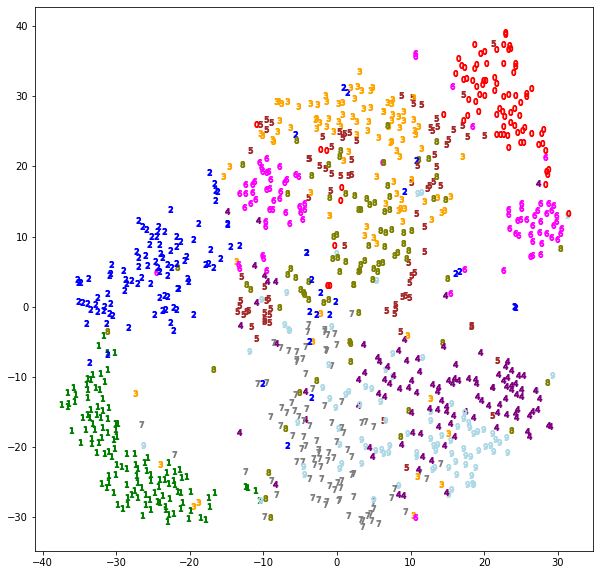

In [8]:
from sklearn.manifold import TSNE
from random import random

colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
def visualize_zs(zs, labels):
  plt.figure(figsize=(10,10))
  points = TSNE(n_components=2, random_state=0).fit_transform(zs)
  for p, l in zip(points, labels):
    plt.scatter(p[0], p[1], marker="${}$".format(l), c=colors[l])
  plt.show()

model.eval()
zs = []
for x, t in dataloader_valid:
    x = x.to(device)
    t = t.to(device)
    # generate from x
    _, z, _ = model(x, device)
    z = z.cpu()
    t = t.cpu()
    visualize_zs(z.detach().numpy(), t.cpu().detach().numpy())
    break

In [11]:
# img = dataloader_train.dataset.data[1]
# plt.imshow(img, cmap='gray')
# plt.show()
eps = torch.randn(10, device=device)
oness = torch.from_numpy(np.ones(10)).to(device)
print('mu:',oness)
print('ep:',eps)
print('mu+ep:',oness+eps)
print('z:', torch.exp(0.5 * torch.randn(10)))

# mean + epsilon*torch.exp(0.5 * log_var)


mu: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       dtype=torch.float64)
ep: tensor([ 0.1772, -0.4512,  0.8728, -0.0478, -0.6621,  1.4982, -0.7735, -0.0364,
        -0.1722,  0.1802], device='cuda:0')
mu+ep: tensor([1.1772, 0.5488, 1.8728, 0.9522, 0.3379, 2.4982, 0.2265, 0.9636, 0.8278,
        1.1802], device='cuda:0', dtype=torch.float64)
z: tensor([0.8712, 0.9317, 1.1989, 0.4828, 0.5100, 1.4016, 0.7169, 1.2263, 0.3718,
        0.4837])
